In [1]:
'''
Installing packages for rendering the game on Colab
'''

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1
!pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.5 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.6.0
    Uninstalling setuptools-67.6.0:
      Successfully uninstalled setuptools-67.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 77.2 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.3.0
    Uninstalling pygame-2.3.0:
      Successfully uninstalled pygame-2.3.0


In [2]:
import numpy as np
import random
import torch
import torch.nn as nn  
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp

In [3]:
env = gym.make('CartPole-v1')
env.seed(0)

state_shape = env.observation_space.shape[0]
no_of_actions = env.action_space.n

print(state_shape)
print(no_of_actions)
print(env.action_space.sample())
print("----")

state = env.reset()   

print(state)
print("----")

action = env.action_space.sample()  

print(action)
print("----")

next_state, reward, done, info = env.step(action) 

print(next_state)
print(reward)
print(done)
print(info)
print("----")

4
2
1
----
[ 0.01369617 -0.02302133 -0.04590265 -0.04834723]
----
1
----
[ 0.01323574  0.17272775 -0.04686959 -0.3551522 ]
1.0
False
{}
----


/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [4]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

class ActorCritic(nn.Module):

    def __init__(self, state_dim, action_dim, hidden1, hidden2):
        super(ActorCritic, self).__init__()

        self.actor = nn.Sequential(
            nn.Linear(state_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, action_dim),
            nn.Softmax(dim=-1),
        )
        self.critic = nn.Sequential(
            nn.Linear(state_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, 1)
        )

    def forward(self, state):
        action_probs = self.actor(state)
        value = self.critic(state)
        return action_probs, value

In [5]:
HIDDEN1 = 128
HIDDEN2 = 64
GAMMA = 0.99
LR = 2e-5
SEED = 101

In [6]:
class Agent_nstep():

  def __init__(self, state_dim, action_dim, gamma = GAMMA, seed = SEED):
    super(Agent_nstep, self).__init__()
    self.gamma = gamma
    self.ac_model = ActorCritic(state_dim, action_dim, HIDDEN1, HIDDEN2)
    self.optimizer = optim.Adam(self.ac_model.parameters(), lr = LR)
    np.random.seed(seed)

  def sample_action(self, state):
    state_tensor = torch.FloatTensor(state).unsqueeze(0)
    action_probs, _ = self.ac_model(state_tensor)
    action = np.random.choice(env.action_space.n, p=action_probs.detach().numpy()[0])
    return action

  def actor_loss(self, action_probs, actions, advantage):
    actor_loss = -torch.log(action_probs[0, actions[0]]) * advantage.detach()
    return actor_loss

  def critic_loss(self, advantage):
    return advantage.pow(2)

  def learn(self, states, actions, rewards, state, action, reward, done, n_steps):

    if len(states) >= n_steps:
        n_step_return = 0
        for j in range(n_steps):
            n_step_return += (self.gamma ** j) * rewards[j]

        n_step_state = torch.FloatTensor(states[-1]).unsqueeze(0)
        _, n_step_value = self.ac_model(n_step_state)
        n_step_return += (self.gamma ** n_steps) * n_step_value.detach().numpy()[0]

        state_i = torch.FloatTensor(states[0]).unsqueeze(0)
        _, value_i = self.ac_model(state_i)
        advantage = torch.tensor(n_step_return) - value_i

        action_probs, _ = self.ac_model(state_i)
        actor_loss = self.actor_loss(action_probs, actions, advantage)
        critic_loss = self.critic_loss(advantage)
        total_loss = actor_loss + critic_loss

        self.optimizer.zero_grad()
        total_loss.backward()
        self.optimizer.step()
        
    if done:
        for i in range(1, n_steps):
            n_step_return = 0
            for j in range(i):
                n_step_return += (self.gamma ** j) * rewards[n_steps-i+j]
            
            n_step_state = torch.FloatTensor(states[-1]).unsqueeze(0)
            _, n_step_value = self.ac_model(n_step_state)
            n_step_return += (self.gamma ** i) * n_step_value.detach().numpy()[0]

            state_i = torch.FloatTensor(states[i]).unsqueeze(0)
            _, value_i = self.ac_model(state_i)
            advantage = torch.tensor(n_step_return) - value_i

            action_i_probs, _ = self.ac_model(state_i)
            actor_loss = -torch.log(action_i_probs[0, actions[-i]]) * advantage.detach()
            critic_loss = advantage.pow(2)
            total_loss = actor_loss + critic_loss

            self.optimizer.zero_grad()
            total_loss.backward()
            self.optimizer.step()

In [8]:
total_rewards = []
n_steps = 5

for i in range(5):
  env = gym.make('Acrobot-v1')
  env.seed(SEED)
  state_dim = env.observation_space.shape[0]
  action_dim = env.action_space.n
  reward_list = []
  begin_time = datetime.datetime.now()
  agent = Agent_nstep(state_dim, action_dim)
  num_episodes = 10000
  for episode in range(1, num_episodes+1):
    state = env.reset()
    done = False
    episode_reward = 0
    states, actions, rewards = deque(maxlen=n_steps+1), deque(maxlen=n_steps+1), deque(maxlen=n_steps+1)

    while not done:
      action = agent.sample_action(state)
      next_state, reward, done, info = env.step(action)
      episode_reward += reward
      states.append(state)
      actions.append(action)
      rewards.append(reward)
      agent.learn(states, actions, rewards, state, action, reward, done, 5)
      state = next_state

    reward_list.append(episode_reward)

    if episode < 100:
      avg_rew = np.mean(reward_list)
      print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, avg_rew), end="")
      if avg_rew > -300:
        print('Stopped at Episode ',episode)
        break
    if episode >= 100:
      avg_rew = np.mean(reward_list[-100:])
      print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, avg_rew), end="")
    if episode%100 == 0:
      avg_rew = np.mean(reward_list[-100:])
      print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, avg_rew))

    if episode >= 100:
      avg_100 =  np.mean(reward_list[-100:])
      if avg_100 > -300:
        print('Stopped at Episode ',episode)
        break
 
  total_rewards.append(reward_list)

  time_taken = datetime.datetime.now() - begin_time
  print(time_taken)

Episode 100	Average Score: -357.45
Episode 119	Average Score: -299.96Stopped at Episode  119
0:01:21.859243
Episode 100	Average Score: -432.43
Episode 163	Average Score: -299.71Stopped at Episode  163
0:02:05.130763
Episode 100	Average Score: -404.45
Episode 153	Average Score: -298.83Stopped at Episode  153
0:01:50.717745
Episode 100	Average Score: -360.87
Episode 124	Average Score: -298.50Stopped at Episode  124
0:01:23.679034
Episode 100	Average Score: -413.70
Episode 149	Average Score: -299.33Stopped at Episode  149
0:01:53.923381


In [12]:
import seaborn as sns
def plot_mean_and_variance(mean_array, std_array):
    x = np.arange(len(mean_array))
    plt.plot(x, mean_array, label='Mean')
    plt.fill_between(x, mean_array - std_array, mean_array + std_array, alpha=0.2, label='Standard Deviation')
    sns.set_style('darkgrid')
    plt.xlabel('Episodes', fontsize = 16)
    plt.ylabel('Reward', fontsize = 16)

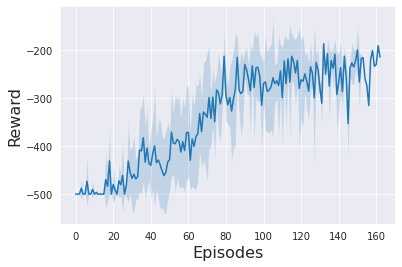

In [13]:
def tolerant_mean(arrs):
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.mean(axis = -1), arr.std(axis=-1)

y, error = tolerant_mean(total_rewards)
plot_mean_and_variance(y, error)

In [11]:
variance = sum(error)/len(error)
print(variance)

56.53316638790551
